[View in Colaboratory](https://colab.research.google.com/github/AnujArora23/CreditApproval/blob/master/CreditApprovalPrediction.ipynb)

#Credit Approval Prediction (Binary Classification)

This dataset is an excellent example of how to deal with sensitive/obscure data. Domain knowledge, while advantageous, is not a necessity and we will see how to develop a good predictive model with domain expertise!


This dataset is posted in this project's GitHub repository, while in this notebook I have ingested it through Google Drive. Feel free to replace the ingestion method with your own!

### Dataset information:

**Credit_Scoring_Clean.csv**: This dataset contains several features that govern an individual's application for credit. We do not know when this dataset is from, and if this is for a credit card application, or a loan, or any other form of credit. In addition to this, many of the features have been converted to meaningless categorical variables or scaled numerical ones, to protect the data of the individual. The outcome is binary, where a *1* implies a successful application for credit and *0* implies an unsuccessful application. 

Also, as can be gleaned from the file name, the dataset does not require any clean up.

### Goals:



1.   Perform feature selection to eliminate unnecessary variables or those that introduce bias.

2.   Develop a predictive model to judge future credit applications.

3. Compare with other models to see if prediction can be improved.



## Install and import necessary libraries

In [18]:
!pip3 install -U -q PyDrive #Only if you are loading your data from Google Drive

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score, roc_curve,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

## Authorize Google Drive (if your data is stored in Drive)

In [0]:
%%capture
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Data Ingestion

I have saved the file in my personal drive storage and read it from there into a pandas data frame. Please modify the following cells to read the CSV files into a Pandas dataframe as per your storage location.

In [0]:
%%capture
downloaded = drive.CreateFile({'id':'1JeSjiGe_bbQ9L0xtb0c7hc4V047-XNJa'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Credit_Scoring_Clean.csv')  
creditdata = pd.read_csv('Credit_Scoring_Clean.csv') 

##Feature Selection

###Feature Elimination

**Let's take a look at the dataset and their features, to see if we can derive any insights from it.**

In [22]:
creditdata.head()

,CheckingAcctStat,Duration,CreditHistory,Purpose,CreditAmount,Savings,Employment,InstallmentRatePecnt,SexAndStatus,OtherDetorsGuarantors,...,Property,Age,OtherInstalments,Housing,ExistingCreditsAtBank,Job,NumberDependents,Telephone,ForeignWorker,CreditStatus
0,A11,0.205882,A32,A43,0.161770,A61,A73,0.333333,A92,A101,...,A121,0.089286,A143,A152,0.0,A173,0.0,A191,A201,1
1,A14,0.294118,A32,A43,0.058380,A62,A74,1.000000,A94,A101,...,A122,0.125000,A143,A152,0.0,A173,0.0,A192,A201,0
2,A14,0.205882,A32,A43,0.069055,A61,A73,1.000000,A93,A101,...,A124,0.232143,A143,A153,0.0,A174,0.0,A192,A201,0
3,A11,0.647059,A32,A43,0.358094,A61,A73,0.666667,A92,A101,...,A123,0.214286,A143,A152,0.0,A173,0.0,A192,A201,1
4,A13,0.029412,A33,A43,0.023825,A61,A72,0.333333,A92,A101,...,A122,0.178571,A141,A152,0.0,A173,0.0,A191,A201,0


**As we can see there are about 20 features, and a 'CreditStatus' (approval status) feature which needs to be predicted. One can also notice the obscure nature of the data. Just by looking at it, one can make no sense of the observations.**

**A summary and list of all features is shown below.**

In [23]:
creditdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 21 columns):
CheckingAcctStat         950 non-null object
Duration                 950 non-null float64
CreditHistory            950 non-null object
Purpose                  950 non-null object
CreditAmount             950 non-null float64
Savings                  950 non-null object
Employment               950 non-null object
InstallmentRatePecnt     950 non-null float64
SexAndStatus             950 non-null object
OtherDetorsGuarantors    950 non-null object
PresentResidenceTime     950 non-null float64
Property                 950 non-null object
Age                      950 non-null float64
OtherInstalments         950 non-null object
Housing                  950 non-null object
ExistingCreditsAtBank    950 non-null float64
Job                      950 non-null object
NumberDependents         950 non-null float64
Telephone                950 non-null object
ForeignWorker            950 non-

**From the above list, we can eliminate a few features simply by seeing what they represent.**

**Since we do not want to discriminate against any group in our model, it makes sense to eliminate features like *SexAndStatus* and *Age*. In addition to this, certain features are absolutely unnecessary and should not influence the model like *Telephone* and *PresentResidenceTime *.**

In [0]:
creditdata.drop(['SexAndStatus','Age','Telephone','PresentResidenceTime'],axis=1,inplace=True)

**We will now convert the categorical features to categorical dataypes in pandas.**

In [0]:
cols=['CheckingAcctStat','CreditHistory','Purpose','Savings','Employment','OtherDetorsGuarantors','Property','OtherInstalments','Housing','Job','ForeignWorker']
creditdata[cols]=creditdata[cols].apply(lambda x: x.astype('category'))   

###Pointwise Mutual Information (PMI) Test 

**PMI is a way to do feature selection between categorical variables and I think the best way to define it is using Scikit-learn's definition:**


> *Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.*

**It is essentially a measure of association between two categorical variables where a higher PMI score implies higher associativity. Refer to the [Wikipedia link](https://en.wikipedia.org/wiki/Pointwise_mutual_information) for a detailed mathematical description of the measure.**


In [0]:
flatten = lambda k: [item for sublist in k for item in sublist] #List flattening function

In [27]:
featselX=creditdata.select_dtypes(include=['category'])
featselX=pd.get_dummies(featselX)
featselY=creditdata[['CreditStatus']]
feature_scores=mutual_info_classif(featselX.values,flatten(featselY.values))
print('PMI scores for each group is: ')
print()
for iter,row in zip(featselX.columns,feature_scores):
  print(str(iter),':',str(row))

PMI scores for each group is: 

CheckingAcctStat_A11 : 0.024556564943028825
CheckingAcctStat_A12 : 0.0
CheckingAcctStat_A13 : 0.0
CheckingAcctStat_A14 : 0.06985790579065654
CreditHistory_A30 : 0.03634662098976338
CreditHistory_A31 : 0.026387579186726517
CreditHistory_A32 : 0.004393759564439881
CreditHistory_A33 : 0.0
CreditHistory_A34 : 0.027213404094643012
Purpose_A40 : 0.0
Purpose_A41 : 0.007678656569794384
Purpose_A410 : 0.0
Purpose_A42 : 0.0
Purpose_A43 : 0.0
Purpose_A44 : 0.0
Purpose_A45 : 0.0
Purpose_A46 : 0.0
Purpose_A48 : 0.0
Purpose_A49 : 0.0
Savings_A61 : 0.0
Savings_A62 : 0.0
Savings_A63 : 0.0010983167170088848
Savings_A64 : 0.01979479183315158
Savings_A65 : 0.007057334469012355
Employment_A71 : 0.0
Employment_A72 : 0.013070259055987021
Employment_A73 : 0.0026911105353606413
Employment_A74 : 0.009717850691805863
Employment_A75 : 0.01972215297706792
OtherDetorsGuarantors_A101 : 0.0037963077524612032
OtherDetorsGuarantors_A102 : 0.0
OtherDetorsGuarantors_A103 : 0.0
Property_A1

**The PMI scores are displayed for each group of each categorical feature. Note that we had to make dummy variables for each group of every categorical feature because any machine learning algorithm will accept categorical features only when they're converted to indicator variables.**

**As we can see, there are quite a few zeros in the output, which can be easily eliminated but before we make a decision to drop any features, we will check with another method of feature selection.**

### Chi Square Test

**The Chi Square test needs no introduction, it is one of the most basic yet powerful associativity tests for categorical variables. Using this test, we either reject the null hypothesis ($H_0$ : *There is no association between the two variables*) if our p value is less than the significance level ($\alpha$) or we fail to reject it.**

**To read more about the chi square test of independence, one can visit [this link](http://www.statisticssolutions.com/non-parametric-analysis-chi-square/).**

**The p values for each feature can be seen below.**

In [28]:
feature_scores =chi2(featselX.values,flatten(featselY.values))
print('p values for all groups are:')
print()
for iter,row in zip(featselX.columns,feature_scores[1]):
  print(str(iter),':',str(row))

p values for all groups are:

CheckingAcctStat_A11 : 3.909040187610065e-12
CheckingAcctStat_A12 : 0.00034879107948464374
CheckingAcctStat_A13 : 0.0061543731740452134
CheckingAcctStat_A14 : 1.3575381267791174e-21
CreditHistory_A30 : 4.82657953132884e-05
CreditHistory_A31 : 5.8323618737951896e-05
CreditHistory_A32 : 0.2234909115148053
CreditHistory_A33 : 0.9999999999999991
CreditHistory_A34 : 5.663689922062244e-09
Purpose_A40 : 3.78922020444793e-06
Purpose_A41 : 0.0003140980228330038
Purpose_A410 : 0.076510552575717
Purpose_A42 : 0.5635101721453828
Purpose_A43 : 0.0008763214346722448
Purpose_A44 : 0.9618174435035914
Purpose_A45 : 0.23845477532844392
Purpose_A46 : 0.9237222779031785
Purpose_A48 : 0.06189492847027719
Purpose_A49 : 0.15385443181361183
Savings_A61 : 0.026239039231359965
Savings_A62 : 0.1217270204448923
Savings_A63 : 0.10984226445386511
Savings_A64 : 0.0716887215113875
Savings_A65 : 8.075802618518415e-05
Employment_A71 : 0.07741577460984586
Employment_A72 : 0.0002363697406189

**We will choose a standard significance level of 5%, and hence if our p value is less than 0.05, we can reject the null hypothesis. If p value is greater than 0.05 for ALL groups of a particular feature, we can safely eliminate that feature as it has no bearing to the outcome.**

**Using this logic, we can eliminate the *Job*, *OtherInstalments* and *OtherDetorsGuarantors* features. The remaining features have at least one group which has a significant association to the outcome. The low PMI scores for these features also corroborate our decision! **

**In regard to the continuous variables, we do not need to worry about them. The classifier we choose will automatically adjust the weights for them. We take categorical variables for feature selection because a categorical variable with *n* groups results in *n* features. Hence it is significantly more expensive, computationally. Also, in our attempt to not overfit the model, we shouldn't end up underfitting it due to the elimination of more features than necessary.**

**We now eliminate the features that we decided above and move on to prediction. We also sort the data into the feature matrix and the labels matrix to get it ready for the machine learning model(s).**

In [0]:
creditdata.drop(['Job','OtherInstalments','OtherDetorsGuarantors'],axis=1,inplace=True)

In [0]:
X=pd.get_dummies(creditdata, drop_first=True) #We drop the first group of each categorical feature to not fall into the dummy variable trap
X.drop(['CreditStatus'],axis=1,inplace=True)
X=X.values
y=creditdata.CreditStatus.values

##Prediction

###Split Data: Training and Testing

**We split the data to use 80% of it for training our machine learning models, and the remaining 20% for testing.**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

###Class distribution

**A large part of how we decide which Machine Learning model to choose will depend on the class distribution. **

In [32]:
unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 425]
 [  1 525]]


**So we have significantly more class labels of 1 than we do of 0 i.e. we have more approvals for credit than rejections. This skew can introduce a bias in our model, and hence we need to be careful with our scoring method.**

**We chose the F1 score as a measure of model performance as we have an uneven class distribution (we have more ones than zeros in our class labels). For a more detailed explanation (and formulae), please see [this link.](https://blogs.msdn.microsoft.com/andreasderuiter/2015/02/09/performance-measures-in-azure-ml-accuracy-precision-recall-and-f1-score/)**

###Method 1: Logistic Regression

####Hyperparameter Tuning

**We tune the regularization parameter (*C*) for logistic regression using a 10 fold cross validated Grid Search, using our training set. Notice, that we have set the grid search to maximize the F1 score for our model. **

In [0]:
def lgr_param_selection(X, y, nfolds):
  Cs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,2,2.5,3]
  param_grid = {'C': Cs}
  grid_search = GridSearchCV(LogisticRegression(max_iter=1000,solver='sag',penalty='l2'), param_grid, cv=nfolds,scoring='f1')
  grid_search.fit(X, y)
  grid_search.best_params_
  return grid_search.best_params_

In [34]:
lgr_param_selection(X_train, y_train, 10)

{'C': 0.5}

**The Grid Search has yielded a regularization parameter (C) of 0.5. Note that we have used the L2 norm penalty, as L1/Elastic Net would perform automatic feature selection for us, which we have already done in the previous section.**

**We now apply this parameter to create a logistic regression model for analysis, and then run a 10 fold cross validation to check if we have a good model that is not overfitted.**

####Model Fitting and Analysis

In [35]:
logreg = LogisticRegression(max_iter=1000,solver='sag',penalty='l2',C=0.5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Logistic Regression predicts the correct class label with a',str(round(accuracy_score(y_test, y_pred)*100,2)),'% accuracy.')

Logistic Regression predicts the correct class label with a 75.79 % accuracy.


In [36]:
kfold=KFold(n_splits=10, random_state=0)
modelCV = LogisticRegression(max_iter=1000,solver='sag',penalty='l2',C=0.5)
scoring = 'f1'
results = cross_val_score(modelCV, X_train, y_train, cv=kfold,scoring=scoring)
print("10-fold average cross validation average F1 score: %.3f" % (results.mean()))

10-fold average cross validation average F1 score: 0.782


**The entire classification report can be seen below. *Support* just refers to the number of observations of that particular class:**

In [37]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.71      0.70      0.71        79
          1       0.79      0.80      0.79       111

avg / total       0.76      0.76      0.76       190



**The ROC curve (and the Area Under the Curve i.e. AUC) is a useful metric to measure the performance of binary classifiers. The red (y=x) line represents a classifer based on random guessing (50% accuracy). Ideally the AUC should be 1 (a perfect elbow curve going to the origin and moving along the X axis), for a perfect classifier but that is impossible to do without overfitting the data.**

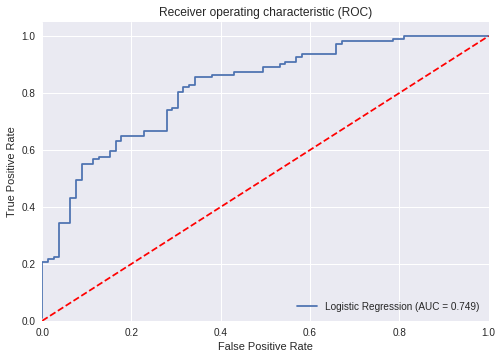

In [38]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.3f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

###Method 2: K-Nearest Neighbours (KNN)

####Hyperparameter Tuning

**In the case of KNN, we tune the type of distance metric used and the number of nearest neigbours considered in classification.**

In [0]:
def knn_param_selection(X, y, nfolds):
  n_neighborss = [3,4,5,6,7,8,9,10,11,12,13,14,15]
  metrics=['minkowski','euclidean','manhattan']
  param_grid = {'n_neighbors': n_neighborss,'metric':metrics}
  grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=nfolds,scoring='f1')
  grid_search.fit(X, y)
  grid_search.best_params_
  return grid_search.best_params_

In [40]:
knn_param_selection(X_train, y_train, 10)

{'metric': 'manhattan', 'n_neighbors': 3}

**The grid search reveals that we should use the *manhattan* distance metric and the *three nearest neighbours* to maximize the F1 score.**

####Model Fitting and Analysis

In [41]:
knnclass = KNeighborsClassifier(n_neighbors=3,metric='manhattan')  
knnclass.fit(X_train, y_train)  
y_pred = knnclass.predict(X_test) 
print('K-Nearest Neighbors predicts the correct class label with a',str(round(accuracy_score(y_test, y_pred)*100,2)),'% accuracy.')

K-Nearest Neighbors predicts the correct class label with a 71.58 % accuracy.


In [42]:
kfold=KFold(n_splits=10, random_state=0)
modelCV = KNeighborsClassifier(n_neighbors=3,metric='manhattan')
scoring = 'f1'
results = cross_val_score(modelCV, X_train, y_train, cv=kfold,scoring=scoring)
print("10-fold average cross validation average F1 score: %.3f" % (results.mean()))

10-fold average cross validation average F1 score: 0.766


**Classification Report:**

In [43]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.72      0.52      0.60        79
          1       0.71      0.86      0.78       111

avg / total       0.72      0.72      0.71       190



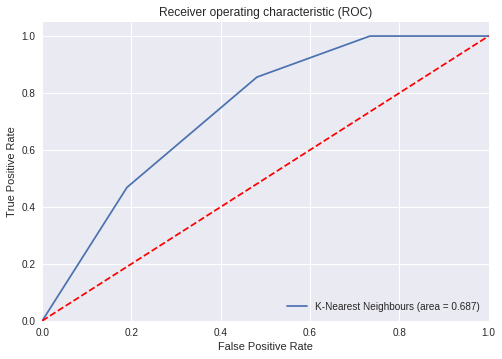

In [44]:
knn_roc_auc = roc_auc_score(y_test, knnclass.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knnclass.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='K-Nearest Neighbours (area = %0.3f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

###Method 3: Support Vector Classifier with Linear Kernel

####Hyperparameter Tuning

In [0]:
def linsvc_param_selection(X, y, nfolds):
  Cs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,2,2.5,3]
  param_grid = {'C': Cs}
  grid_search = GridSearchCV(LinearSVC(), param_grid, cv=nfolds,scoring='f1')
  grid_search.fit(X, y)
  grid_search.best_params_
  return grid_search.best_params_

In [46]:
linsvc_param_selection(X_train, y_train, 10)

{'C': 0.1}

####Model Fitting and Analysis

In [47]:
clf = LinearSVC(C=0.1)
linsvc = CalibratedClassifierCV(clf) 
linsvc.fit(X_train, y_train)
y_pred=linsvc.predict(X_test) 
print('Linear SVC predicts the correct class label with a',str(round(accuracy_score(y_test, y_pred)*100,2)),'% accuracy.')

Linear SVC predicts the correct class label with a 74.21 % accuracy.


In [48]:
kfold=KFold(n_splits=10, random_state=0)
modelCV = CalibratedClassifierCV(LinearSVC(C=0.1)) 
scoring = 'f1'
results = cross_val_score(modelCV, X_train, y_train, cv=kfold,scoring=scoring)
print("10-fold average cross validation average F1 score: %.3f" % (results.mean()))

10-fold average cross validation average F1 score: 0.778


**Classification Report:**

In [49]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.69      0.70      0.69        79
          1       0.78      0.77      0.78       111

avg / total       0.74      0.74      0.74       190



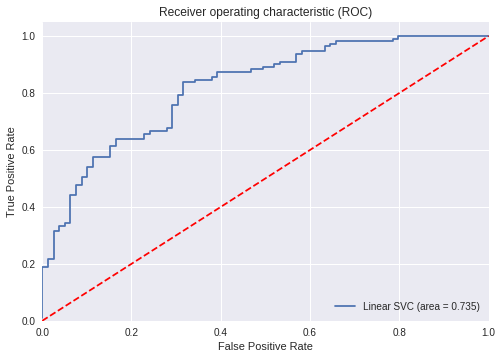

In [50]:
lsvc_roc_auc = roc_auc_score(y_test, linsvc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, linsvc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Linear SVC (area = %0.3f)' % lsvc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

###Method 4: Random Forest Classifier (Ensemble Method)

####Hyperparameter Tuning

**Since Random Forest is an ensemble learning method (similar to bagged decision trees), our critical parameters are the ones that select the number of trees to compare and the pruning parameter (minimum samples to split a node).**

In [0]:
def randf_param_selection(X, y, nfolds):
  n_estimatorss = [30,60,90,100,150,200]
  min_samples_splits=[5,10,20,30,40,50]
  param_grid = {'n_estimators': n_estimatorss,'min_samples_split':min_samples_splits}
  grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=nfolds,scoring='f1')
  grid_search.fit(X, y)
  grid_search.best_params_
  return grid_search.best_params_

In [52]:
randf_param_selection(X_train,y_train,10)

{'min_samples_split': 5, 'n_estimators': 200}

####Model Fitting and Analysis

In [57]:
randf=RandomForestClassifier(n_estimators=200,min_samples_split=5)
randf.fit(X_train,y_train)
y_pred=randf.predict(X_test)
print('Random Forest predicts the correct class label with a',str(round(accuracy_score(y_test, y_pred)*100,2)),'% accuracy.')

Random Forest predicts the correct class label with a 84.21 % accuracy.


In [58]:
kfold=KFold(n_splits=10, random_state=7)
modelCV = RandomForestClassifier(n_estimators=200,min_samples_split=5)
scoring = 'f1'
results = cross_val_score(modelCV, X_train, y_train, cv=kfold,scoring=scoring)
print("10-fold cross validation average F1 score: %.3f" % (results.mean()))

10-fold cross validation average F1 score: 0.822


**Classification Report:**

In [59]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.82      0.81        79
          1       0.87      0.86      0.86       111

avg / total       0.84      0.84      0.84       190



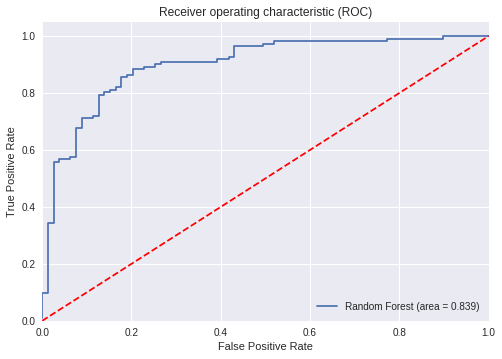

In [60]:
randf_roc_auc = roc_auc_score(y_test, randf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, randf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.3f)' % randf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

###Summary

**To sum up, we have performed feature selection on our categorical variables using two popular tests and have used the L2 penalty in our machine learning algorithms. This is because we do not want L1/Elastic Net to perform automatic feature selection, as that might remove some of the groups of any categorical feature, which is not a good idea. After this, we developed several predictive models to classify whether a line of credit should be approved or not.**

**The classifiers ranked in order of worst to best, are shown below. The values may vary slightly as there are some random processes involved in the grid search and each algorithm.**




| Classifier | Accuracy | F1 | AUC
| --- | --- | --- |
| K-Nearest Neighbours | 71.58% |0.71 | 0.687
| Linear SVC | 74.21% | 0.74 | 0.735
| Logistic Regression | 75.79% | 0.76 | 0.749
| Random Forest | 84.21% | 0.84| 0.839

**As we can see above, the Random Forest classifier has performed the best out of all the classifiers, while the K-Nearest Neighbours classifier has performed the worst.**


**Since our class distribution was unequal, we used the F1 score as our primary performance metric. To eliminate any issues with overfitting, we calculated a 10 fold cross validated F1 score, and used accuracy and AUC as secondary metrics. Based on this, the Random Forest algorithm beats the others by a significant margin and this is because of it being an ensemble method.**

**Ensemble methods combine a number of weak classifiers (binary trees in this case) to enhance the final predicition. Random Forests are similar to bagged decision trees, and are a powerful, albeit computationally expensive algorithm.**